In [ ]:
!pip install kaggle shap lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7dd7d46a1572ea1fef14fa9ce09f59006142e91db3cbd0808c47a6c3308b88f0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from google.colab import files
files.upload()

In [ ]:
import zipfile

with zipfile.ZipFile('/content/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

STEP 3 — Import Libraries

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array


Load & Preprocess Dataset

In [ ]:
IMG_SIZE = 150
data = []
labels = []

tumor_path = 'data/yes'
normal_path = 'data/no'

for img in os.listdir(tumor_path):
    img_arr = cv2.imread(os.path.join(tumor_path, img))
    img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    data.append(img_arr)
    labels.append(1)

for img in os.listdir(normal_path):
    img_arr = cv2.imread(os.path.join(normal_path, img))
    img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    data.append(img_arr)
    labels.append(0)

In [ ]:
data = np.array(data) / 255.0
labels = np.array(labels)


Train/Validation Split (90/10 split from paper)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    data, labels, test_size=0.10, random_state=42, shuffle=True)


Build Customized CNN Architecture

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,497 (7.64 MB)

 Trainable params: 2,002,497 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

Train Model (30 Epochs)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val)
)


Epoch 1/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6829 - loss: 0.5764 - val_accuracy: 0.8500 - val_loss: 0.3588
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.8528 - loss: 0.3464 - val_accuracy: 0.9267 - val_loss: 0.2544
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9304 - loss: 0.1890 - val_accuracy: 0.8933 - val_loss: 0.2819
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9516 - loss: 0.1313 - val_accuracy: 0.9633 - val_loss: 0.1564
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.9787 - loss: 0.0731 - val_accuracy: 0.9733 - val_loss: 0.1300
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9950 - loss: 0.0213 - val_accuracy: 0.9733 - val_loss: 0.1384
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9923 - loss: 0.0299 - val_accuracy: 0.9700 - val_loss: 0.1584
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.9948 - loss: 0.0129 - val_accuracy: 0.9767 - v

Plot Training & Validation Graphs

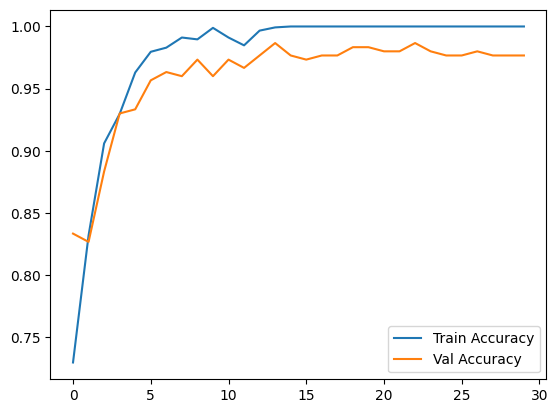

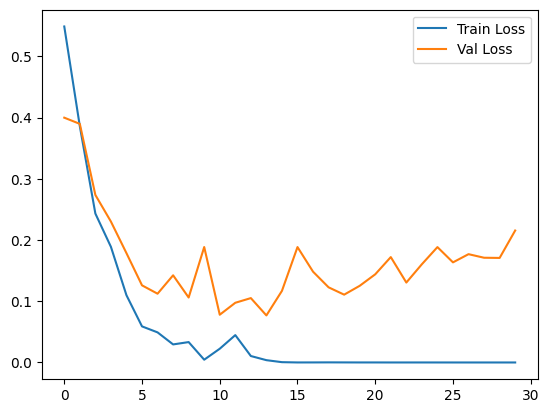

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


Evaluate Model Using Metrics Used in Paper

In [ ]:
pred = model.predict(X_val)
pred = (pred > 0.5).astype(int)

acc = accuracy_score(y_val, pred)
prec = precision_score(y_val, pred)
rec = recall_score(y_val, pred)
f1 = f1_score(y_val, pred)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Accuracy: 0.9766666666666667
Precision: 0.9625
Recall: 0.9935483870967742
F1 Score: 0.9777777777777777


Confusion Matrix

In [ ]:
cm = confusion_matrix(y_val, pred)
cm


array([[139,   6],
       [  1, 154]])

10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 551ms/step


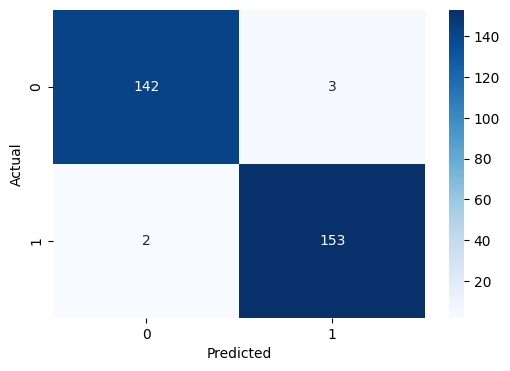

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Recalculate pred to ensure it's defined
pred = model.predict(X_val)
pred = (pred > 0.5).astype(int)

cm = confusion_matrix(y_val, pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Apply SHAP

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 150, 150, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 150, 150, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(5, 150, 150,

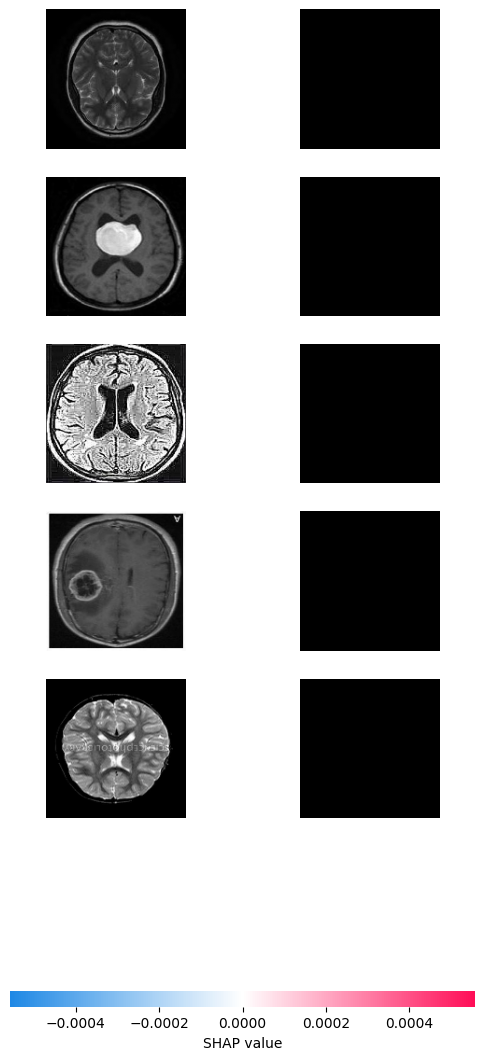

In [ ]:
import shap

background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(X_val[:5])

shap.image_plot(shap_values, X_val[:5])


Apply LIME

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d22391d43ea3a231a795c561ed11c648a3eb2bf51a465d6b6aba263102ccd93c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━

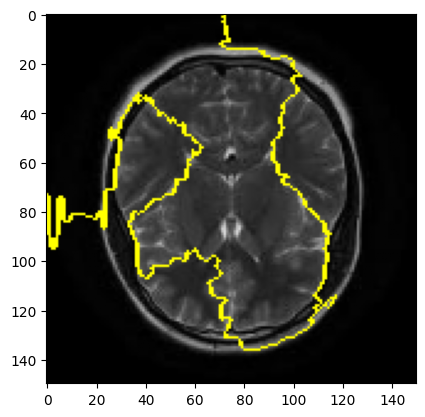

In [ ]:
!pip install lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

i = 0   # test image index
explanation = explainer.explain_instance(
    X_val[i].astype('double'),
    model.predict,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=10,
    hide_rest=False
)

plt.imshow(mark_boundaries(temp, mask))
plt.show()

Apply Grad-CAM

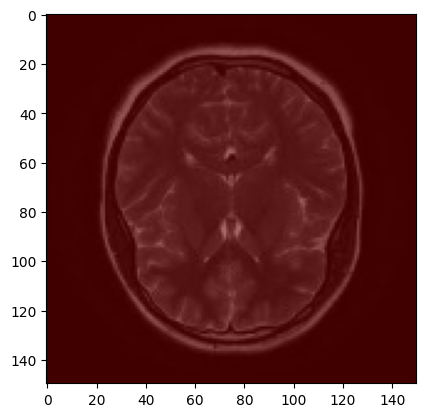

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(img_array, model, last_conv_layer_name="conv2d_3"):
    # Access the input and output tensors explicitly from the model's layers
    input_tensor = model.layers[0].input
    output_tensor = model.layers[-1].output

    # Create a model that maps the input image to the activations of the last convolutional layer
    # and the model's final output.
    grad_model = tf.keras.models.Model(
        inputs=input_tensor,
        outputs=[model.get_layer(last_conv_layer_name).output, output_tensor]
    )

    with tf.GradientTape() as tape:
        # Cast the input image array to a TensorFlow tensor and explicitly watch it
        inputs_tensor = tf.cast(img_array, tf.float32)
        tape.watch(inputs_tensor)

        conv_output, predictions = grad_model(inputs_tensor)
        # Assuming binary classification, we want the gradient with respect to the predicted class score
        loss = predictions[:, 0]

    # Compute gradients of the top predicted class with respect to the activations of the last conv layer
    grads = tape.gradient(loss, conv_output)

    # Global average pooling of the gradients to get a weight for each feature map
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each feature map in the conv_output by its corresponding weight
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 and 1 (add epsilon for stability)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

i = 0
input_img = X_val[i][np.newaxis, ...]

# Explicitly call the model once to ensure its input/output tensors are fully defined
# This line is crucial for Sequential models before accessing model.layers[0].input etc.
_ = model(input_img)

heatmap = grad_cam(input_img, model)

# Resize heatmap to original image size and apply colormap
heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Superimpose heatmap on original image. Blend more carefully.
superimposed = heatmap * 0.5 + X_val[i] * 255 * 0.5
plt.imshow(superimposed.astype('uint8'))
plt.show()

hsshssjs

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap
import tensorflow as tf

IMG_SIZE = 150

# ---------------------------
# GRAD-CAM FUNCTION
# ---------------------------
def grad_cam(input_image, model, last_layer="conv2d_3"):
    # Access the input and output tensors explicitly from the model's layers
    input_tensor = model.layers[0].input
    output_tensor = model.layers[-1].output

    # Create a model that maps the input image to the activations of the last convolutional layer
    # and the model's final output.
    grad_model = tf.keras.models.Model(
        inputs=input_tensor,
        outputs=[model.get_layer(last_layer).output, output_tensor]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_image)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap # Removed .numpy() as heatmap is already a numpy array

# ---------------------------
# MAIN AUTOMATED FUNCTION
# ---------------------------
def analyze_brain_mri(img_path):
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    # Explicitly call the model once to ensure its input/output tensors are fully defined
    # This line is crucial for Sequential models before accessing model.layers[0].input etc.
    _ = model(img_input)

    # Prediction
    pred = model.predict(img_input)[0][0]
    label = "Tumor" if pred > 0.5 else "No Tumor"

    print("Prediction:", label, "| Confidence:", float(pred))

    # SHOW ORIGINAL IMAGE
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Uploaded Image: {label}")
    plt.axis('off')
    plt.show()

    # ------------------ GRAD-CAM ------------------
    heatmap = grad_cam(img_input, model)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    gradcam_result = heatmap * 0.5 + img

    plt.figure(figsize=(5,5))
    plt.imshow(gradcam_result.astype("uint8"))
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()

    # ------------------ LIME ------------------
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_norm.astype("double"),
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    plt.figure(figsize=(5,5))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation")
    plt.axis("off")
    plt.show()

    # ------------------ SHAP ------------------
    # Use X_train which is already a numpy array for SHAP background
    background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
    explainer = shap.DeepExplainer(model, background)
    shap_values = explainer.shap_values(img_input)

    shap.image_plot(shap_values, img_input)

In [ ]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    uploaded_image_path = fn   # store the file name to use later


Saving no0.jpg to no0 (6).jpg


# **Implementation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: No Tumor | Confidence: 3.3479145261288146e-19


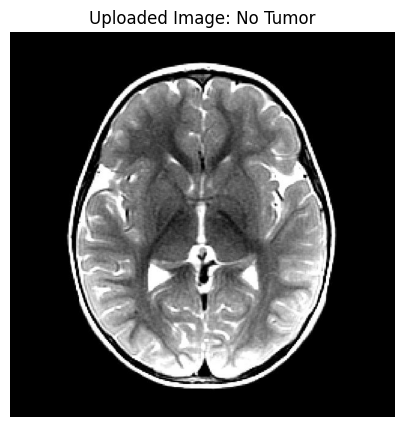

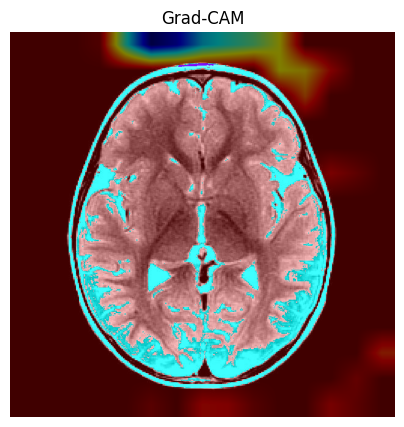

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

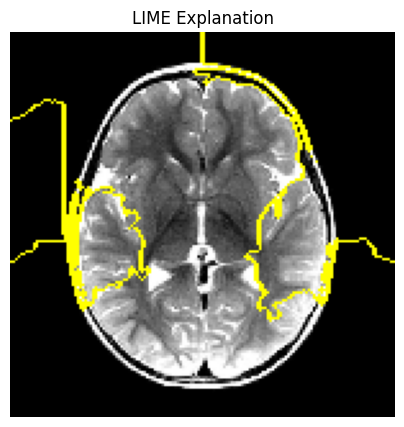

/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 150, 150, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 150, 150, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 150, 150,

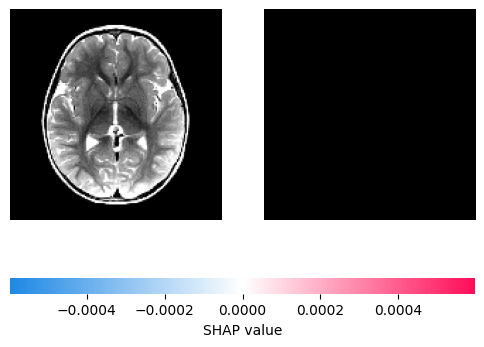

In [ ]:
analyze_brain_mri(uploaded_image_path)

In [ ]:
# save model and background
model.save("model.h5")
np.save("data_background.npy", X_train[:100])


In [ ]:
from google.colab import files
files.download("model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("data_background.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>